# TRABAJO FIN DE GRADO: Predicción de ventas - series temporales

Predicción de ventas: un enfoque integral con series temporales y aprendizaje automático


#### Bibliotecas

In [1]:
# Bibliotecas básicas Python
import pandas as pd
import numpy as np

# Gestión de warnings
import warnings

# Graficas
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Descomposition de Series Temporales
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
# ACF y PACF: funciones de autocorrelación y autocorrelación parcial
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Búsqueda de parámetros GridSearchCV
from sklearn.model_selection import GridSearchCV

# Modelos clásicos de series temporales
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# REGRESIÓN
# Aprendizaje automático y modelado estadístico
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

# CLASIFICACIÓN
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# Modelos profundos
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
import tensorflow as tf

# RNN
from tensorflow.keras.layers import Dense, SimpleRNN, Input
# LSTM
from tensorflow.keras.layers import LSTM
# GRU
from tensorflow.keras.layers import GRU
# CNN
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

# Métricas para evaluar modelo
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Prueba estadística para determinar si una serie temporal es estacionaria.
from statsmodels.tsa.stattools import adfuller

#### **Seleción producto**

##### **GARGANTILLA BOLITAS DE PLATA, 44CM TOUS CHAIN**
 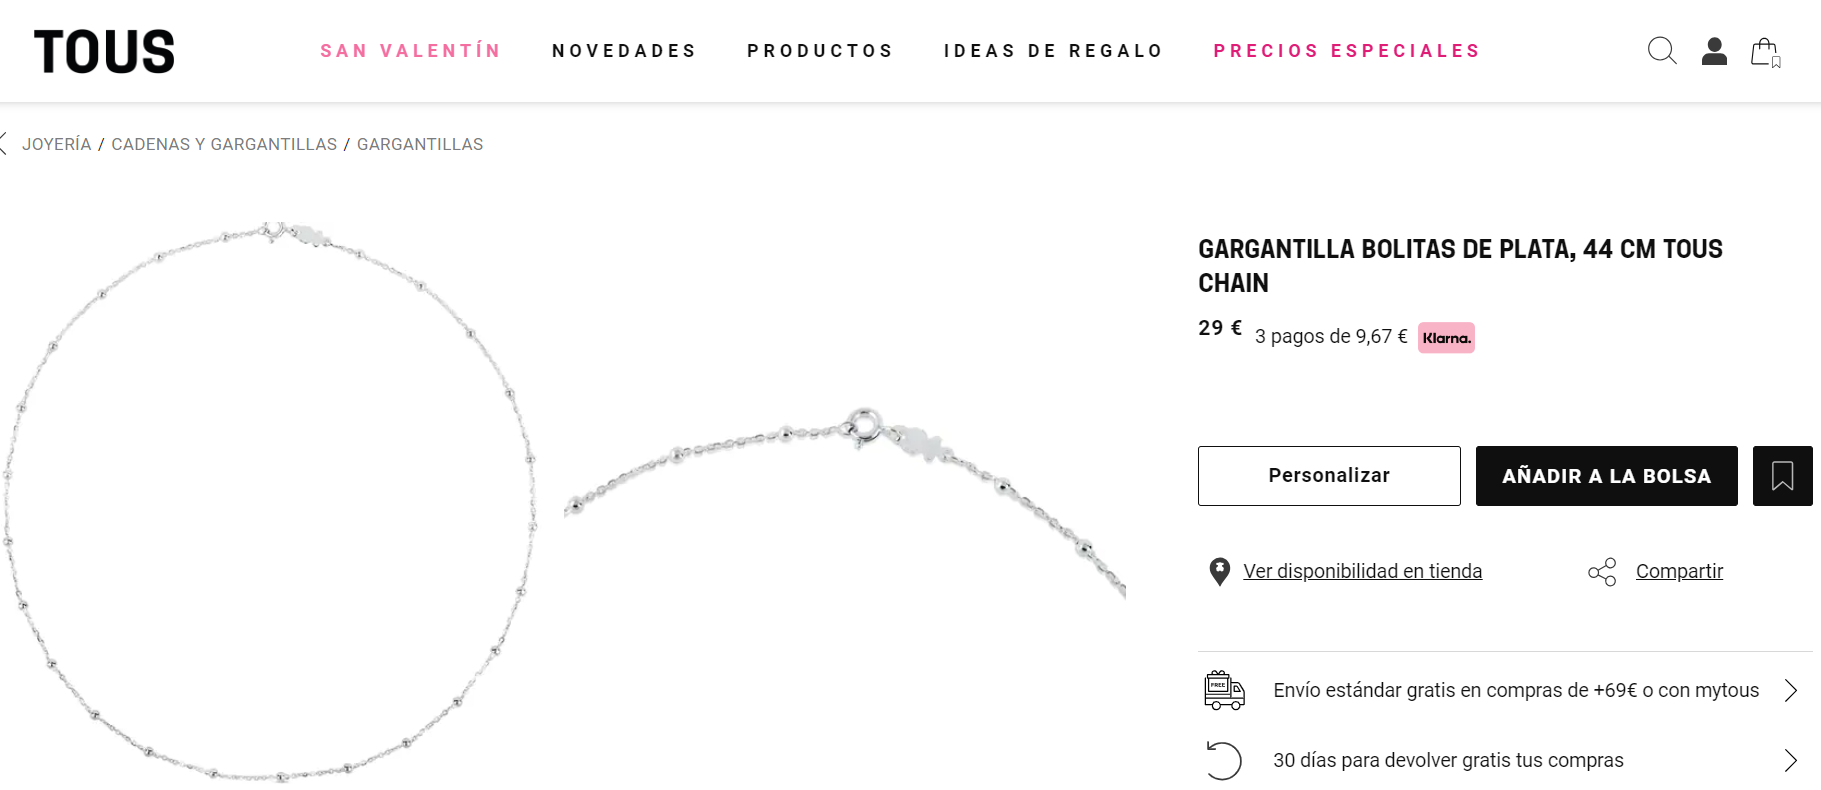

https://www.tous.com/es-es/gargantilla-bolitas-de-plata-44cm-tous-chain/p/211902540

**Criterios de Selección del Producto:** 
- **Relevancia en el mercado.** Se ha optado por un producto con mayor volumen de ventas en una tienda relevante. Así asegurar una base de datos amplia y eficiente para el entrenamiento de modelos de aprendizaje.
- **Accesibilidad económica.** Producto con precio asequible asociandolo a un mayor número de ventas y una demanda más estable, lo que facilita el análisis de patrones y tendencias de ventas a lo largo del tiempo
- **Disponibilidad y permanencia en el mercado.** Producto permanente que está a la venta de manera continua desde al menos 2020, garantizando un conjunto de datos históricos suficiente para realizar un análisis exahustivo de series temporales. Además, la permanencia del producto en el mercado sugiere una demanda estable y predecible.

### VARIABLES DE ENTRADA - DIARIO

#### Importación de archivos para las variables de entrada -  (2020-06-15 HASTA 2024-01-08)

In [2]:
# Número de unidades de venta al día
archivo = 'G:\\Mi unidad\\TFG\\Extracción Agosto\\TotalSales_2017_2024.csv'
salesProduct = pd.read_csv(archivo)
salesProduct = salesProduct.rename(columns={'effectiveDate':'date'})
salesProduct['date'] = pd.to_datetime(salesProduct['date'], format='%Y-%m-%d')
# salesProduct.head() # 2017-01-02  / 2024-08-04   

# Número de cuentas nuevas al día
archivo = 'G:\\Mi unidad\\TFG\\Extracción Agosto\\NewAccounts_2017_2024.csv'
accountsTous = pd.read_csv(archivo)
accountsTous = accountsTous.rename(columns={'firstPurchaseDate':'date'})
accountsTous['date'] = pd.to_datetime(accountsTous['date'], format='%Y-%m-%d')
# accountsTous.head() # 2007-01-04  / 2024-08-05

# Google Analytics 3
# Eventos del producto al día -> view_item & add_to_cart
archivo = 'G:\\Mi unidad\\TFG\\Extracción Agosto\\eventosGA3_202006_2024_06.csv'
events_oldTable = pd.read_csv(archivo)
events_oldTable = events_oldTable.rename(columns={'productSKU':'idProduct'})
events_oldTable['date'] = pd.to_datetime(events_oldTable['date'], format='%Y%m%d')
events_oldTable['eventAction'] = events_oldTable['eventAction'].replace({
    'productDetail': 'view_item',
    'addToCart': 'add_to_cart'
})
# events_oldTable.head() # 2020-06-15  /  2024-06-29

**Criterios de Selección de variables de entrada:** 

La selección para la variable de entradas permiten la captura de aspectos de comportamiento del consumidor así como las tendencias del mercado. Además permitir la precisión de los modelos de predicción. 
- **Número de ventas Diarias:** variable objetio que se desea predecir. Representando el número total de unidades vendidas del producto en un día. Sistema de gestión de ventas de la tienda
- **Número de nuevas cuentas registradas:** Número de nuevos usuarios registrados en tienda web. Un incremento en el número de nuevas cuentas puede ser un indicador de un aumento potencial de las ventas. Sistema de gestión de usuarios
- **Número de visitas a la página del producto:** (Google Analytics 3) muestra las veces que ha sido visitada la página web del producto. Podría ser un indicador clave del interés de los consumidores: un mayor número de visitas puede correlacionarse con un aumento en las ventas, puesto que se muestra atención e interés en el producto. 
- **Número de veces añadido al carrito:** (Google Analytics 3) siendo un paso intermedio crucial en el proceso de compra, por lo que es un predictor fuerte de las ventas futuras, ya que refleja una intención clara de compra. 


La selección adel dato ha sido a nivel diario desde 2020 hasta 2024 permitiendo capturar tendencias de largo plazo y patrones recurrentes, incluir eventos especiales como festividades, fechas de promociones, o impactos de eventos externos (covid) que afectan a las ventas y darle densidad a los datos, importante para el entrenamiento de modelos.

Debido a la disponibilidad de datos históricos desde 2020 en GA3, se ha decidido mantener consistencia y continuidad en las escalas de tiempo y datos recopilados, evitando la mezcla con GA4, que solo tiene datos a partir de 2023.

### Preparación y Limpieza de Datos para Modelado

In [3]:
# En este caso quedarnos solo con GA3 para no cambiar de escalas puesto que GA4 tiene datos solo desde 2023
eventsProduct = events_oldTable.copy()

#Filtro de los eventos view_item
view_item = eventsProduct[eventsProduct['eventAction']=='view_item']
view_item

#Filtro del evento add_to_Cart
add_to_cart =eventsProduct[eventsProduct['eventAction']=='add_to_cart']
add_to_cart

#Merge por separado de los eventos add_toCart y ViewItem para cada día
events_product = pd.merge(add_to_cart, view_item, on=['date', 'idProduct'], how='outer', suffixes=('_cart', '_view'))
events_product = events_product[['idProduct', 'date', 'TotalEvent_view','TotalEvent_cart']]
events_product = events_product.rename(columns={'TotalEvent_cart':'Event_AddToCart', 'TotalEvent_view':'Event_ViewItem'})
events_product

# Merge para obtener el resto de variables: ventas, cuentas, etc
product = pd.merge(events_product, salesProduct, on='date', how='left')
product = pd.merge(product, accountsTous, on='date', how='left')
product = product[product['date']<'2024-06-15']
product['TotalSales'] = product['TotalSales'].astype(int)
product['NewAccounts'] = product['NewAccounts'].astype(int)
#No vamos a tener en cuenta las cuentas acumuladas porque es redundante con las cuentas registradas al día
#product['CumulativeNewAccounts'] = product['CumulativeNewAccounts'].astype(int)
product[['idProduct', 'date', 'Event_ViewItem', 'Event_AddToCart', 'TotalSales',
       'NewAccounts']]#, 'CumulativeNewAccounts']]

#Selección de variables para modelado
product = product[['date','Event_ViewItem','Event_AddToCart','NewAccounts', 'TotalSales']]
product.head(3)

,date,Event_ViewItem,Event_AddToCart,NewAccounts,TotalSales
0,2020-06-15,905,171,1895,97
1,2020-06-16,738,128,2076,107
2,2020-06-17,782,137,2012,108


In [4]:
# ruta_salida = 'G:\\Mi unidad\\TFG\\csvFinalproductoGargantilla_Agosto.csv'
# # Exportar el DataFrame a un archivo CSV
# product.to_csv(ruta_salida, index=False)

### Representación variables con respecto al tiempo

#### Número de cuentas nuevas registradas

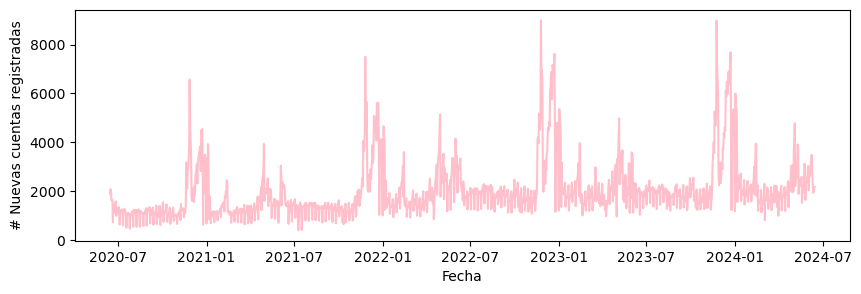

In [5]:
# NewAccounts en el tiempo a nivel diario
plt.figure(figsize=(10, 3))
plt.plot(product['date'], product['NewAccounts'], label='NewAccounts', color='pink')
plt.xlabel('Fecha')
plt.ylabel('# Nuevas cuentas registradas')
plt.show()

#### Número de visitas en página web del producto

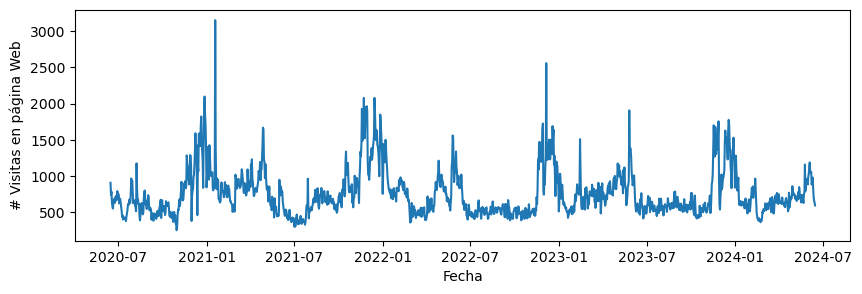

In [6]:
# Event_ViewItem en el tiempo a nivel diario
plt.figure(figsize=(10, 3))
plt.plot(product['date'], product['Event_ViewItem'], label='Event ViewItem')
plt.xlabel('Fecha')
plt.ylabel('# Visitas en página Web')
plt.show()

#### Número de veces añadido al carrito el producto

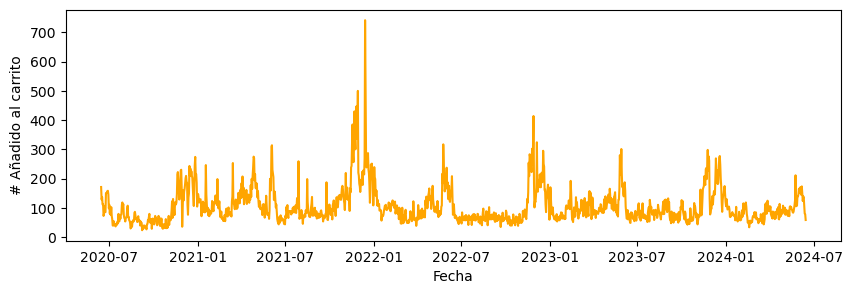

In [7]:
# Event_AddToCart en el tiempo a nivel diario
plt.figure(figsize=(10, 3))
plt.plot(product['date'], product['Event_AddToCart'], label='Event AddToCart', color='orange')
plt.xlabel('Fecha')
plt.ylabel('# Añadido al carrito')
plt.show()

#### Número de Ventas de producto

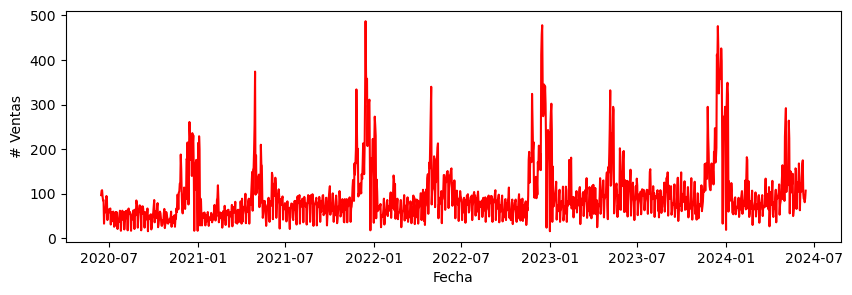

In [8]:
plt.figure(figsize=(10, 3))
plt.plot(product['date'], product['TotalSales'], label='TotalSales', color='red')
plt.xlabel('Fecha')
plt.ylabel('# Ventas')
plt.show()

#### Visualización de todas las variables de entradas juntas

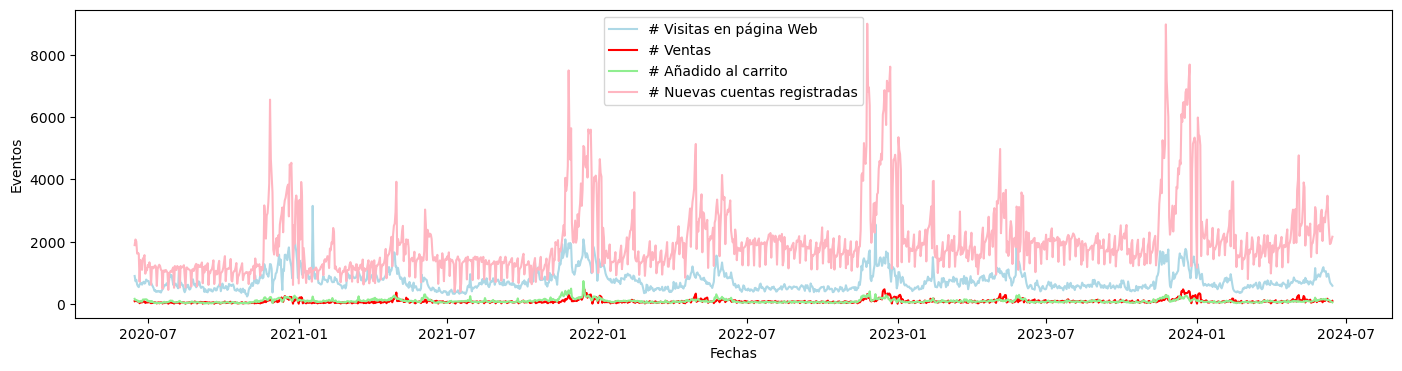

In [9]:
plt.figure(figsize=(17, 4))
plt.plot(product['date'], product['Event_ViewItem'], label='# Visitas en página Web', color= 'lightblue')
plt.plot(product['date'], product['TotalSales'], label='# Ventas', color = 'red')
plt.plot(product['date'], product['Event_AddToCart'], label='# Añadido al carrito', color= 'lightgreen')
plt.plot(product['date'], product['NewAccounts'], label='# Nuevas cuentas registradas', color= 'lightpink')
plt.xlabel('Fechas')
plt.ylabel('Eventos')
plt.legend()
plt.show()

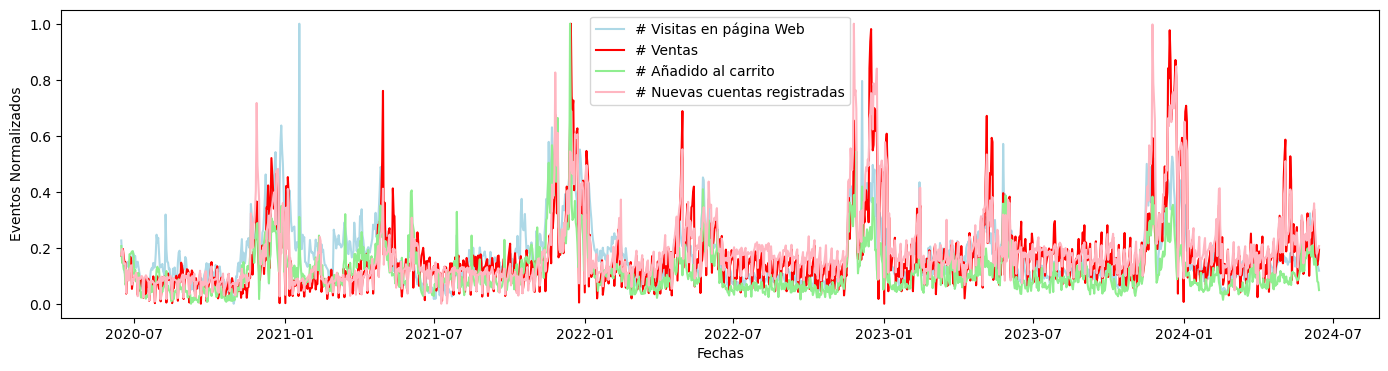

In [10]:
# Normalización permitiendo una mejor comparación visual entre variables
scaler = MinMaxScaler()

# Columnas a escalar
columns_to_scale = ['Event_ViewItem', 'TotalSales', 'Event_AddToCart', 'NewAccounts']
product_scaled = product.copy()
product_scaled[columns_to_scale] = scaler.fit_transform(product[columns_to_scale])

# Graficar las series normalizadas
plt.figure(figsize=(17, 4))
plt.plot(product_scaled['date'], product_scaled['Event_ViewItem'], label='# Visitas en página Web', color='lightblue')
plt.plot(product_scaled['date'], product_scaled['TotalSales'], label='# Ventas', color='red')
plt.plot(product_scaled['date'], product_scaled['Event_AddToCart'], label='# Añadido al carrito', color='lightgreen')
plt.plot(product_scaled['date'], product_scaled['NewAccounts'], label='# Nuevas cuentas registradas', color='lightpink')
plt.xlabel('Fechas')
plt.ylabel('Eventos Normalizados')
plt.legend()

plt.show()

### Descomposición de series temporales

Técnica que permite descomponer una serie temporal en sus componentes básicas: tendencia, estacionalidad y residuo para entender el comportamiento de los datos a lo largo del tiempo. 

C:\Users\victoria.pradas\AppData\Local\Temp\ipykernel_12136\4117584612.py:6: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


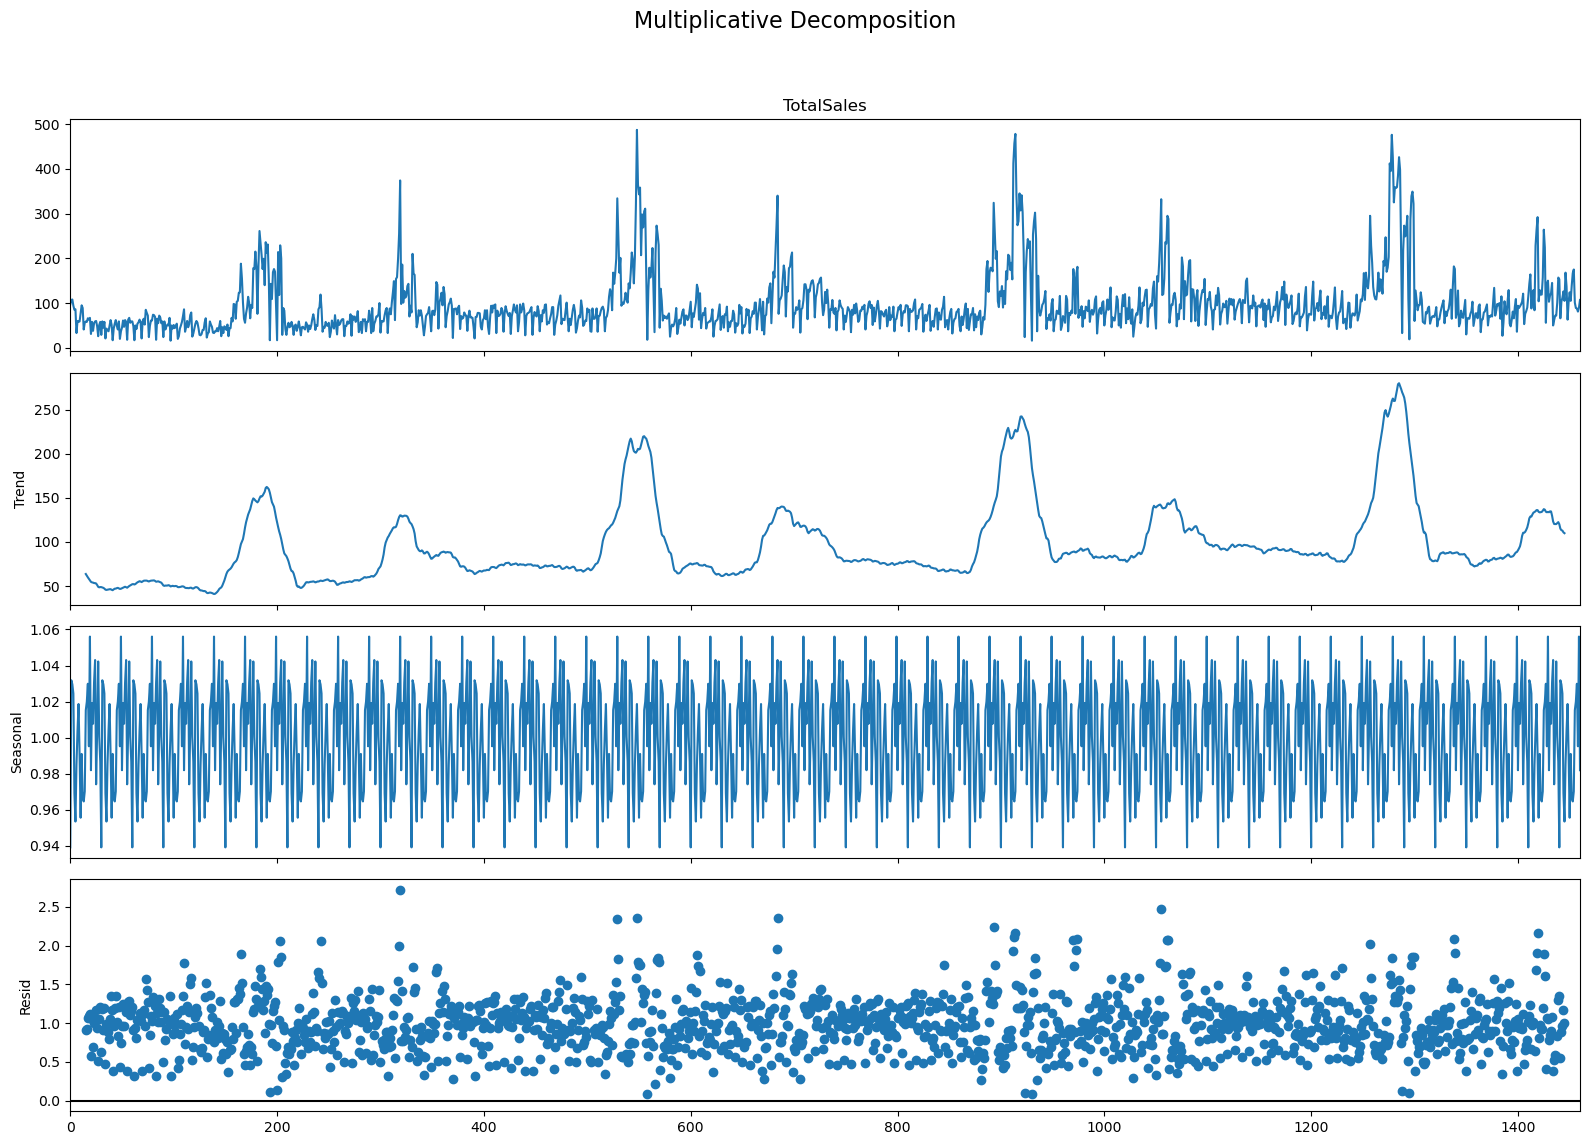

In [11]:
# Multiplicative Decomposition
multiplicative_decomposition = seasonal_decompose(product['TotalSales'], model='multiplicative', period=30)
# Plot
plt.rcParams.update({'figure.figsize': (16,12)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

C:\Users\victoria.pradas\AppData\Local\Temp\ipykernel_12136\1865516453.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


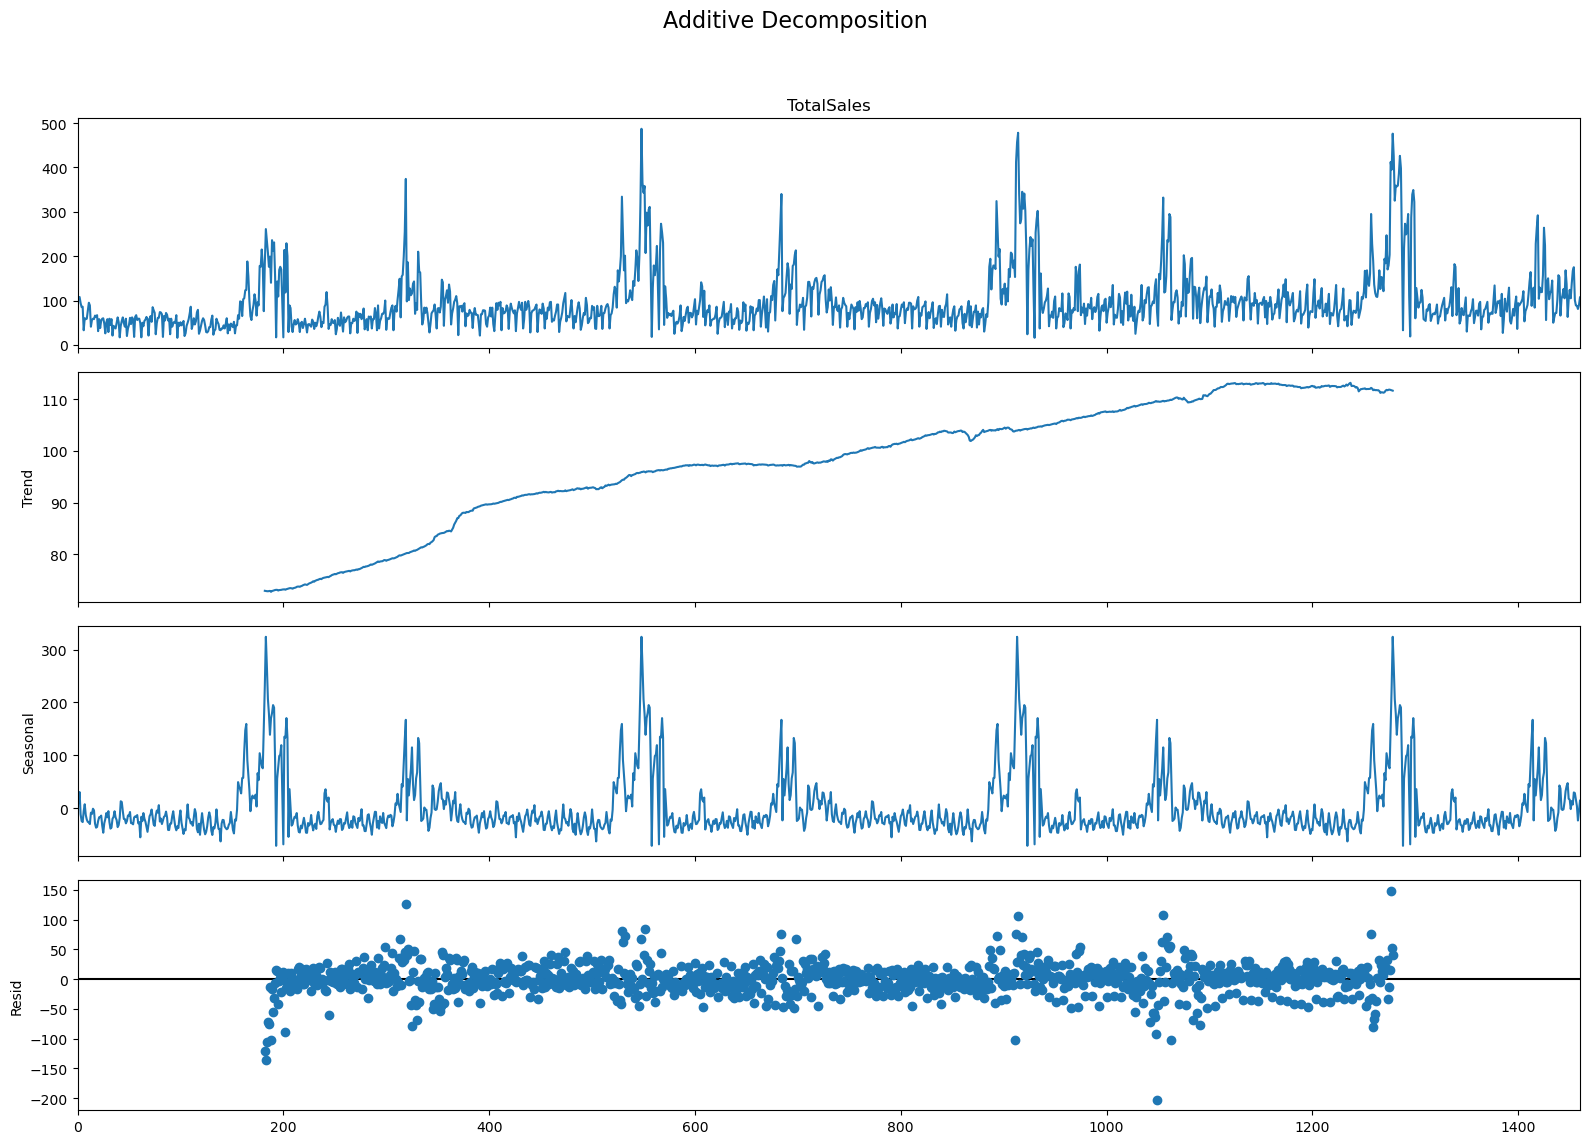

In [12]:
# Additive Decomposition
additive_decomposition = seasonal_decompose(product['TotalSales'], model='additive', period=365)

# Plot
plt.rcParams.update({'figure.figsize': (16,12)})
additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**Descomposición de Series Temporales**

- **Serie original:** muestra las ventas diarias totales del producto desde 15-06-2020 hasta 15-06-2024 observando cambios diarios e incluso alguna tendencia a simple vista.
- **Tendencia:** La tendencia se observa un crecimiento leve pero constante además de picos que muestran las navidades y mitad de año puesto que existen promociones internas al rededor de mayo-junio
- **Estacionalidad:** se observa patrones recurrentes cada 30 días, por lo que se ve que hay una variación regular y cíclica en las ventas. Por lo que podemos determinar que hay patrones repetitivos a nivel mensual en las ventas. De manera anual, vemos un crecimiento de las ventas.
- **Residuo:** captura la variabilidad que n opuede ser explicada por ninguno de los casos anteriores. Todos los casos están en torno a 1.0 en el caso multiplicativo, lo que indica variabilidad aleatoria en los datos. A pesar de ver tendencia y estacionalidad, se observan fluctuaciones diarias no explicadas por los casos anteriores.
En el caso de Additive Decomposition el residuo se encuentra entre -100 y 100.
La variabilidad aleatoria capturada en el residuo indica que hay factores adicionales que influyen en las ventas diarias que no están capturados por las componentes de tendencia y estacionalidad

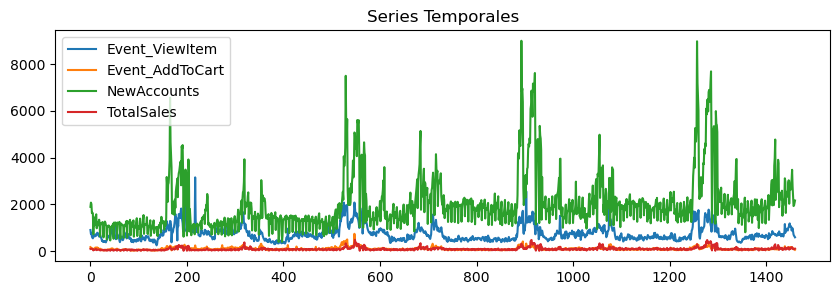

<Figure size 1000x300 with 0 Axes>

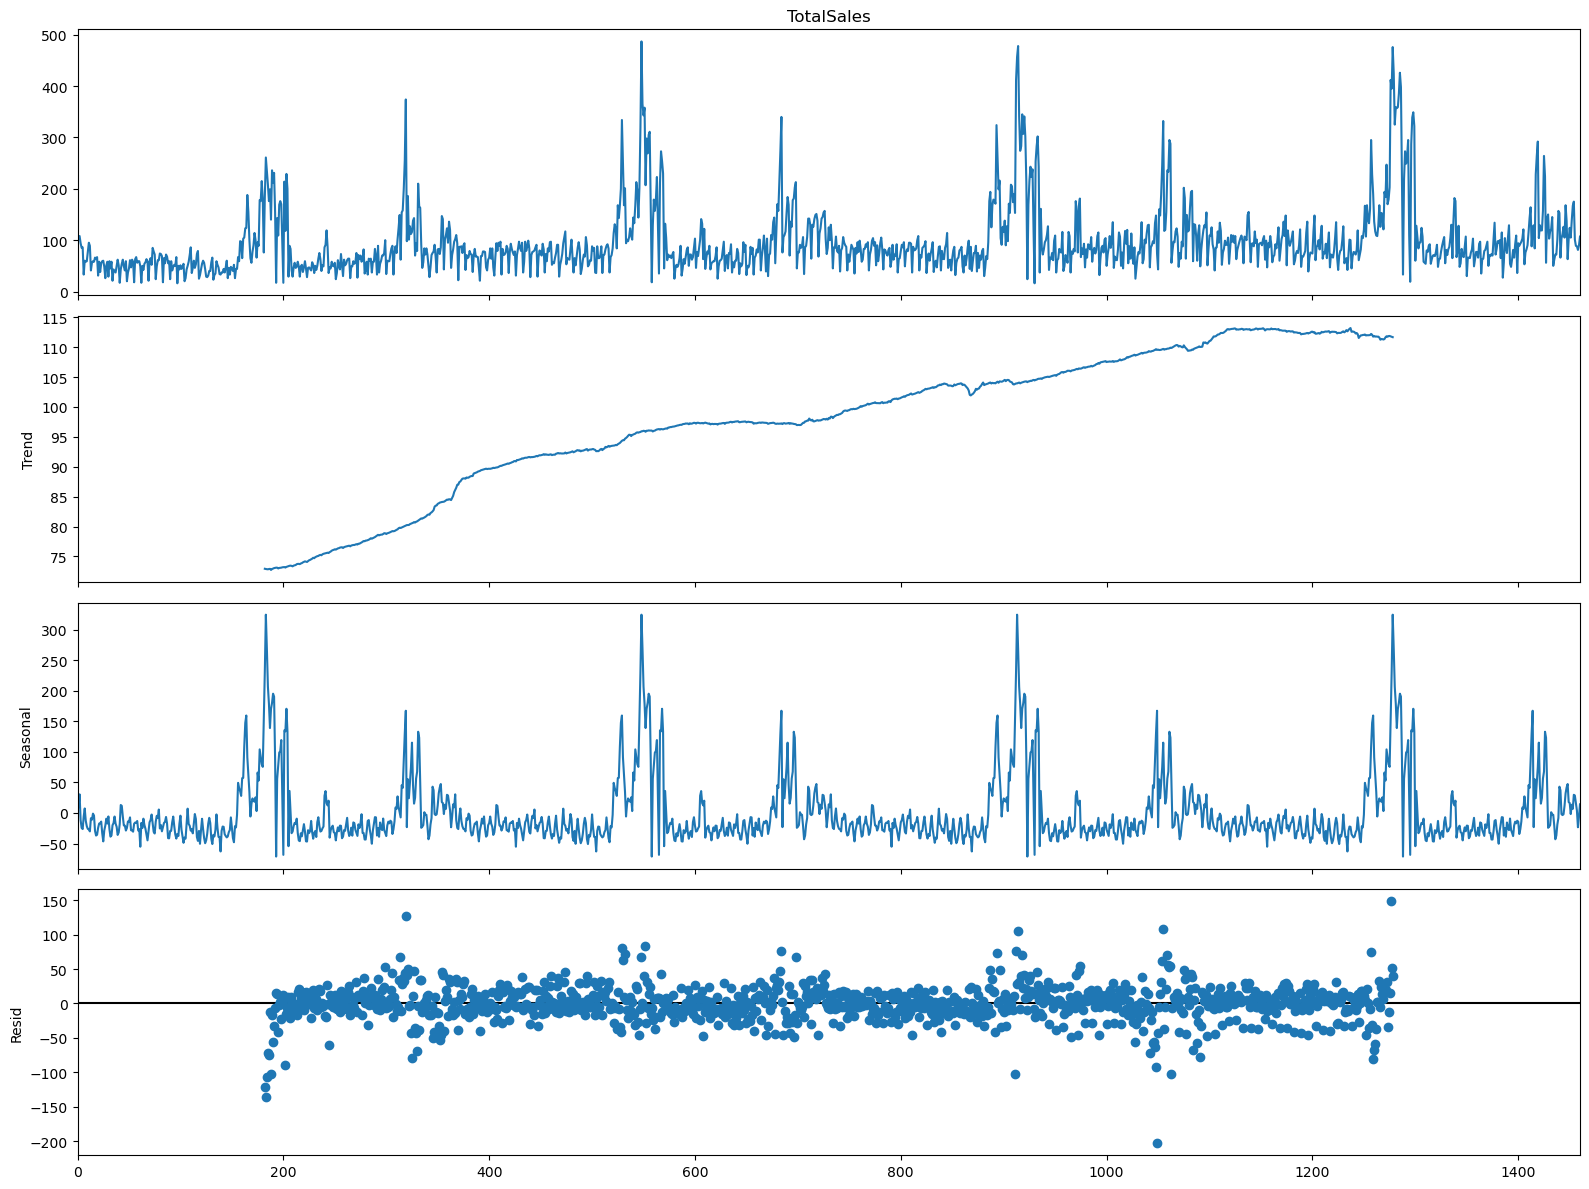

In [13]:
# Visualizar la serie temporal
plt.figure(figsize=(10, 3))
plt.plot(product.index, product['Event_ViewItem'], label='Event_ViewItem')
plt.plot(product.index, product['Event_AddToCart'], label='Event_AddToCart')
plt.plot(product.index, product['NewAccounts'], label='NewAccounts')
plt.plot(product.index, product['TotalSales'], label='TotalSales')
plt.title('Series Temporales')
plt.legend()
plt.show()

# Descomposición de la serie temporal para identificar tendencia, estacionalidad y residuos
result = seasonal_decompose(product['TotalSales'], model='additive', period=365)

# Visualizar las componentes
plt.figure(figsize=(10, 3))
result.plot()
plt.show()

### Serie Diferenciada

La serie diferenciada es una transformación aplicada a una serie temporal para hacerla estacionaria, lo que significa que sus propiedades estadísticas, como la media y la varianza, no cambian con el tiempo. esto es últil porque muchos métodos de análisis de series temporales, como ARIMA, asumen que la serie temporal es estacionaria. Se realiza con diferentes propósitos:
- Estacionariedad. Incluir estacionariedad a la serie temporal, principalmente para los modelos de series temporales.
- Eliminar tendencias. Eliminación de tendencias lineales en la serie temporal.
- Modelado y pronóstico. Modelos como ARIMA, utilizan la serie diferenciada para ajustar el modelo y realizar pronósticos. Una vez ha sido diferenciada y modelada, se vuelve a realizar pronósticos y luego 'revertir' la diferenciación para obtener predicciones en la escala original.

En definitiva, diferencias la serie temporal sería para lograr estacionariedad.

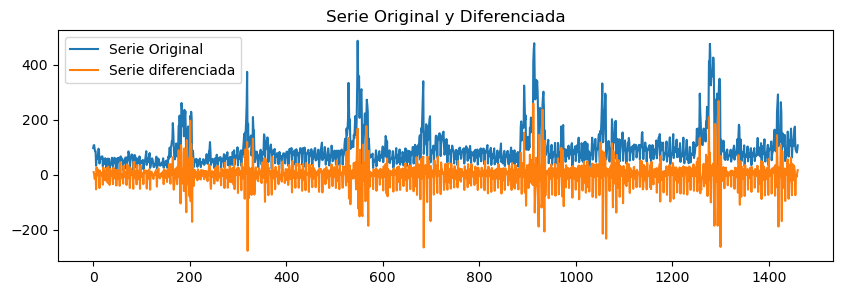

<Figure size 500x500 with 0 Axes>

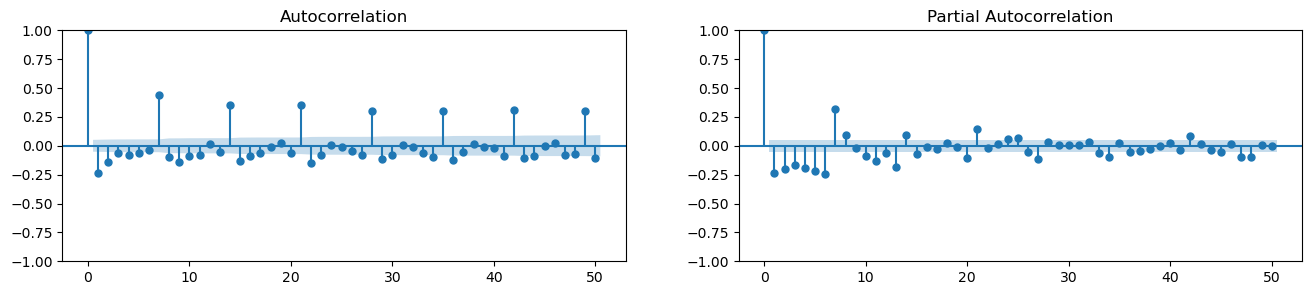

In [14]:
original_series = product['TotalSales']

# Aplicar diferenciación de primer orden
differenced_series = original_series.diff().dropna()

# Visualizar la serie original y la serie diferenciada
plt.figure(figsize=(10, 3))
plt.plot(original_series.index, original_series, label='Serie Original')
plt.plot(differenced_series.index, differenced_series, label='Serie diferenciada')
plt.title('Serie Original y Diferenciada')
plt.legend()
plt.show()

# Calcular y visualizar la ACF y PACF de la serie diferenciada
plt.figure(figsize=(5, 5))
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100);
plot_acf(differenced_series, lags=50, ax=axes[0]);
plot_pacf(differenced_series, lags=50, ax=axes[1]);

### ACF Y PACF EN ANÁLISIS DE SERIES TEMPORALES

Una vez que la serie ha sido diferenciada para lograr la estacionariedad, las funciones ACF y PACF de la serie diferenciada se utilizan para identificar los parámetros u orden de los componente de ARIMA: AR(autorregresivos) y MA(promedio móvil)

- Serie diferenciada:  la serie diferenciada parece más estacionaria que la serie original, lo cual es un buen indicador de que la diferenciación ha ayudado a elminar la tendencia. 
- ACF. La ACF muestra la autocorrelación de la serie diferenciada con sus propios rezagos. En la gráfica, la ACF decae rápidamente, lo cual es una indicación de que la serie diferenciada puede ser adecuada para modelar con un componente de media móvil (MA).
- PACF. La PACF muestra la correlación parcial entre la serie y sus rezagos, eliminando el efecto de los rezagos intermedios. La PACF decae rápidamente, lo cual sugiere que puede haber un componente autorregresivo (AR) de bajo orden

In [15]:
# model_30_1_9 = ARIMA(product['TotalSales'], order=(30, 1, 9))
# result_30_1_9 = model_30_1_9.fit()

# # Comparar los resultados
# print("Resultados para ARIMA(20, 1, 9):")
# print(result_20_1_9.summary())

# # Evaluar el AIC y BIC para decidir el mejor modelo
# print("\nAIC para ARIMA(20, 1, 9):", result_20_1_9.aic)
# print("BIC para ARIMA(20, 1, 9):", result_20_1_9.bic)

# AIC y BIC: Estas son métricas comunes para la comparación de modelos. Valores más bajos indican un mejor ajuste al balancear la bondad del ajuste y la complejidad del modelo. Compara los valores de AIC y BIC entre los modelos para seleccionar el mejor.
# Residuos: Es importante analizar los residuos del modelo ajustado para asegurarse de que no muestren patrones sistemáticos. Residuos aleatorios y con media cero indican un buen ajuste.

### Prueba ADF (Dickey-Fuller aumentada) - Verificar estacionariedad

Esta prueba sirve para verificar la estacionariedad de una serie temporal, siendo esta una propiedad crucial para muchos métodos de análisis de series tempoales. 
Interpretación de los Resultados de la Prueba ADF
- ADF Statistic: Un valor negativo más bajo (más negativo) indica una mayor posibilidad de rechazar la hipótesis nula de una raíz unitaria.
- p-value: Un valor p bajo (generalmente menor a 0.05) indica que se puede rechazar la hipótesis nula, sugiriendo que la serie es estacionaria.

In [16]:
# Serie temporal de ventas
ts = product['TotalSales']

# 1. Verificar estacionaridad
result = adfuller(ts)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Si p-value > 0.05, la serie no es estacionaria, y se requiere diferenciación
if result[1] > 0.05:
    ts_diff = ts.diff().dropna()
    result_diff = adfuller(ts_diff)
    print('ADF Statistic (Diferenciado):', result_diff[0])
    print('p-value (Diferenciado):', result_diff[1])
else:
    ts_diff = ts

ADF Statistic: -5.601674273007266
p-value: 1.2606515847273175e-06


Dado que el valor p de la prueba de Dickey-Fuller aumentado (ADF) es muy bajo (1.26e-06), podemos concluir que la serie temporal de ventas (TotalSales) es estacionaria. Esto significa que no es necesario aplicar diferenciación adicional para hacerla estacionaria.

A pesar de ello, se ha realizado la serie estacionaria puesto que como se observa arriba logra una mejor estacionariedad.

### Análisis de Correlación entre variables

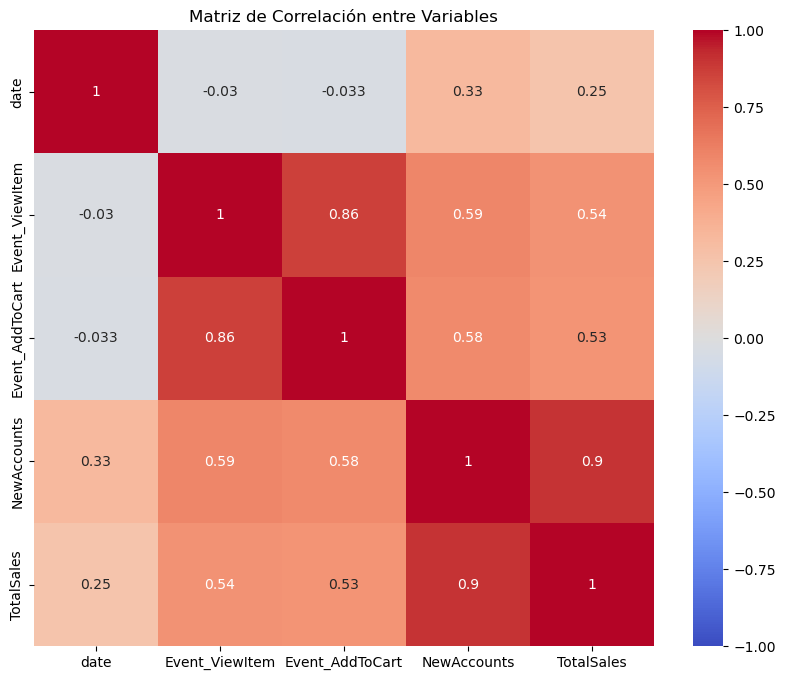

In [17]:
# Calcular la matriz de correlación
correlation_matrix = product.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de Correlación entre Variables')
plt.show()

También es importante visualizar y entender las relacoines entre las variables exógenas y la variable objetivo, que en mi caso sería el número de ventas del producto diaria. 
- Altas correlaciones: nuevas cuentas tiene una correlación muy alta con las ventas totales, sugiriendo un enfoque en atraer nuevos usuarios para impulsar las ventas del producto. Por otro lado, ver el producto y añadir al carrito también presenta una correlación bastante alta. 
- Correlaciones moderadas: añadir al carrito y ver el producto con respecto al número de ventas del producto. 

Esto sugiere que nuevasCuentas podría ser una variable clave en el modelo de forecasting pudiendo mejorar la precisión de las predicciones. Por otro lado, ver el producto y añadirlo al carrito, también podrían ser útiles pero parece tener un impacto más indirecto.

In [18]:
!python --version


Python 3.11.5
